# Intro to Neural Nets
**Suggested time to spend on exercise**: 15 minutes

In the previous exercises, we used synthetic features to help our model incorporate nonlinearities.

One important set of nonlinearities was around latitude and longitude, but there may be others.

In this exercise, we'll explore using neural nets (NN) to learn these nonlinearities as part of training.

We'll also switch back, for now, to a standard regression task, rather than the logistic regression task from the previous exercise. That is, we'll be predicting `medianHouseValue` directly.

First, let's load and prepare the data.

In [10]:
#@test {"output": "ignore"}

%matplotlib inline

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cross_validation import train_test_split
from ml_metrics import rmsle
import xgboost as xgb
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import datasets, linear_model
from datetime import datetime
import tensorflow as tf
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt

def preprocess_features(bimbo_dataframe):
    processed_features = bimbo_dataframe[
        ["d1", "d2", "d3", "d4", "d5", "d6", "p_total_demand", "total_demand"]].copy()
    processed_features["tot_d"] = (
        bimbo_dataframe["d1"]+bimbo_dataframe["d2"]+bimbo_dataframe["d3"]+bimbo_dataframe["d4"]
        +bimbo_dataframe["d5"]+bimbo_dataframe["d6"])
    return processed_features


def preprocess_targets(bimbo_dataframe):
    output_targets = pd.DataFrame()
    output_targets["Demanda_uni_equil"] = (
        bimbo_dataframe["Demanda_uni_equil"])
    return output_targets




# Load in the raw data.  Note that there's a separate test data set that we
# will leave untouched for now.
raw_training_df = pd.read_csv('../../input/train_1000000_alld_totals.csv')
# Randomize the data before selecting train / validation splits.
raw_training_df = raw_training_df.reindex(
  np.random.permutation(raw_training_df.index))

# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(raw_training_df.head(12000))
training_targets = preprocess_targets(raw_training_df.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(raw_training_df.tail(5000))
validation_targets = preprocess_targets(raw_training_df.tail(5000))

### Task 1: Train a NN model

**Adjust hyperparameters, aiming to drop RMSE below 110.**

Run the following block to train a NN model.  The NN is defined by the [DNNRegressor](https://cs.corp.google.com/search/?q=package:piper+symbol:^DNNRegressor$) class.

Recall that in the linear regression exercise with many features, an RMSE of 110 or so was pretty good.  We'll aim to beat that.

Your task here is to modify various learning settings to improve accuracy on validation data.

We have an important new setting to consider exploring: **`hidden_layers`**.

   * Use the `hidden_layers` argument to define the structure of your NN model.

   * Hidden layers are defined by a list of ints, each int showing the number of nodes in that hidden layer.

   * For example, `[3, 10]` show a model with two hidden layers.  The first layer has 3 units, the second has 10.

   * All of our layers will use ReLu activation by default, and they will be fully connected.

Overfitting is a real potential hazard for NN's.  You can look at the gap between loss on training data and loss on validation data to help judge if your model is starting to overfit. If the gap starts to grow, that is usually a sure sign of overfitting.

Because of the number of different possible settings, it's strongly recommended that you take notes on each trial to help guide your development process.

Also, when you get a good setting, try running it multiple times and see how repeatable your result is. NN weights are typically initialized to small random values, so you should see differences from run to run.


In [12]:
#@test {"output": "ignore"}

LEARNING_RATE = 0.01  # @param
STEPS = 50000  # @param
BATCH_SIZE = 10  # @param
HIDDEN_UNITS = [50, 40, 30, 20, 10 ]  # @param
periods = 10
steps_per_period = STEPS / periods

# Set up our NN with the desired learning settings.
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(
    training_examples)
dnn_regressor = tf.contrib.learn.DNNRegressor(
  feature_columns=feature_columns,
  hidden_units=HIDDEN_UNITS,
  optimizer=tf.GradientDescentOptimizer(learning_rate=LEARNING_RATE),
  gradient_clip_norm=5.0
)

print "Training model..."
print "RMSE:"
root_mean_squared_errors_training = []
root_mean_squared_errors_validation = []
for period in range (0, periods):
  dnn_regressor.fit(
    training_examples,
    training_targets,
    steps=steps_per_period,
    batch_size=BATCH_SIZE
  )
  predictions_validation = dnn_regressor.predict(validation_examples)
  predictions_training = dnn_regressor.predict(training_examples)

  root_mean_squared_error_validation = math.sqrt(metrics.mean_squared_error(
    predictions_validation, validation_targets))
  root_mean_squared_error_training = math.sqrt(metrics.mean_squared_error(
    predictions_training, training_targets))

  root_mean_squared_errors_validation.append(root_mean_squared_error_validation)
  root_mean_squared_errors_training.append(root_mean_squared_error_training)

  print "  period %02d : %3.2f" % (period, root_mean_squared_error_training)

# Output a graph of loss metrics over periods.
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(root_mean_squared_errors_training, label='training')
plt.plot(root_mean_squared_errors_validation, label='validation')
plt.legend()

# Display some summary information.
print "Final RMSE (on training data):   %0.2f" % root_mean_squared_error_training
print "Final RMSE (on validation data): %0.2f" % root_mean_squared_error_validation

AttributeError: 'module' object has no attribute 'infer_real_valued_columns_from_input'

Training model...
RMSE:
  period 00 : 165.14
  period 01 : 160.59
  period 02 : 156.34
  period 03 : 150.47
  period 04 : 144.80
  period 05 : 137.41
  period 06 : 129.11
  period 07 : 124.45
  period 08 : 111.80
  period 09 : 108.41
Final RMSE (on training data):   108.41
Final RMSE (on validation data): 109.62


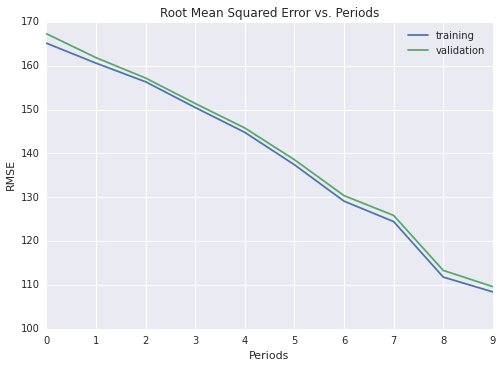

In [0]:
#@title To view a possible solution, toggle Form

#@test {"output": "ignore", "timeout": 180}

# Solution: note that this selection of parameters is somewhat arbitrary - here
# we've tried combinations that are increasingly complex, combined with training
# for longer, until the error falls below our objective. This not by no means
# the best combination - others may attain an even lower RMSE. If your aim is to
# find the model that can attain the best error, then you'll want to use a more
# rigorous process, like a parameter search.

LEARNING_RATE = 0.001
STEPS = 2000
BATCH_SIZE = 100
HIDDEN_UNITS = [10, 10]
periods = 10
steps_per_period = STEPS / periods

# Set up our NN with the desired learning settings.
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(
  training_examples)
dnn_regressor = tf.contrib.learn.DNNRegressor(
  feature_columns=feature_columns,
  hidden_units=HIDDEN_UNITS,
  optimizer=tf.GradientDescentOptimizer(learning_rate=LEARNING_RATE),
  gradient_clip_norm=5.0
)

print "Training model..."
print "RMSE:"
root_mean_squared_errors_training = []
root_mean_squared_errors_validation = []
for period in range (0, periods):
  dnn_regressor.fit(
    training_examples,
    training_targets,
    steps=steps_per_period,
    batch_size=BATCH_SIZE
  )
  predictions_validation = dnn_regressor.predict(validation_examples)
  predictions_training = dnn_regressor.predict(training_examples)

  root_mean_squared_error_validation = math.sqrt(metrics.mean_squared_error(
    predictions_validation, validation_targets))
  root_mean_squared_error_training = math.sqrt(metrics.mean_squared_error(
    predictions_training, training_targets))

  root_mean_squared_errors_validation.append(root_mean_squared_error_validation)
  root_mean_squared_errors_training.append(root_mean_squared_error_training)

  print "  period %02d : %3.2f" % (period, root_mean_squared_error_training)

# Output a graph of loss metrics over periods.
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(root_mean_squared_errors_training, label='training')
plt.plot(root_mean_squared_errors_validation, label='validation')
plt.legend()

# Display some summary information.
print "Final RMSE (on training data):   %0.2f" % root_mean_squared_error_training
print "Final RMSE (on validation data): %0.2f" % root_mean_squared_error_validation

### Task 2: Evaluate on test data

**Confirm that your validation performance results hold up on test data.**

Once you have a model you're happy with, evaluate it on test data to compare that to validation performance.

Reminder, the test data set is located here: `/placer/prod/home/ami/mlcc/california_housing/v1/test.csv`

In [0]:
#
# Your code here: verify the model at Task 1 using the test data.
#

In [0]:
# @title To view a possible solution, toggle Form

#@test {"output": "ignore"}

#
# Solution: Similarly to what the code above does, we just need to load the
# appropriate data file, preprocess it and use predict/mean_squared_error.
#
raw_test_df = pd.read_csv(
  gfile.Open("/placer/prod/home/ami/mlcc/california_housing/v1/test.csv"),
  sep=",")
# Note that we don't have to randomize the test data, since will use all records.

# For testing, we don't need to split the data.
test_examples = preprocess_features(raw_test_df)
test_targets = preprocess_targets(raw_test_df)

# Simply pass the features to the trained model and calculate the error.
test_predictions = dnn_regressor.predict(test_examples)
root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print "Final RMSE (on test data): %0.2f" % root_mean_squared_error

Final RMSE (on test data): 98.47
